# Creating a Basic Machine Learning Model

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [8]:
df = pd.read_csv(r"./udemy-courses-dataset.csv")

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3678 entries, 0 to 3677
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   course_id            3678 non-null   int64  
 1   course_title         3678 non-null   object 
 2   url                  3678 non-null   object 
 3   is_paid              3678 non-null   bool   
 4   price                3678 non-null   int64  
 5   num_subscribers      3678 non-null   int64  
 6   num_reviews          3678 non-null   int64  
 7   num_lectures         3678 non-null   int64  
 8   level                3678 non-null   object 
 9   content_duration     3678 non-null   float64
 10  published_timestamp  3678 non-null   object 
 11  subject              3678 non-null   object 
dtypes: bool(1), float64(1), int64(5), object(5)
memory usage: 319.8+ KB


In [10]:
#published timestamp is stored as an OBJECT
#so we need to convert that to a date time variable

df["published_timestamp"] = pd.to_datetime(df["published_timestamp"])

# Following Steps

1 - Distribution Analysis: What are the common subjects, duration, and price points of courses?

2 - Combining Features: Can we combine any columns for more interesting features?

3 - Comparing Features with Target Variable: Can we get any initial insights on what leads to a successful course?

4 - Building a Model: Can we predict which courses are the most successful?

5 - Improving and Deploying the Model: What are the next steps we can take to build a better model and make it easy fo others access?

## Distribution Analysis

One common way to start is using df.hist() on numerical data, and then plotting bar charts after applying value_counts() on categorical data. We can separate numerical and categorical data using df.select_dtypes(['type'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C2751382C8>,
      dtype=object)

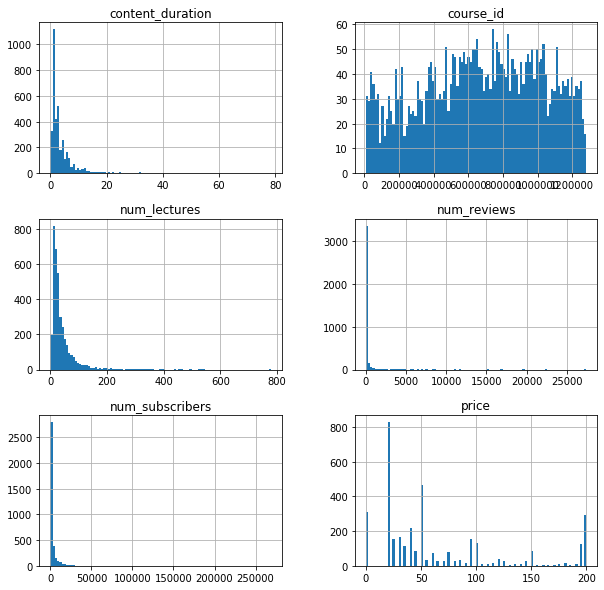

In [11]:
num_cols_df = df.select_dtypes(['int64', 'float64', 'datetime64[ns, UTC]'])
cat_cols_df = df.select_dtypes(['object'])

num_cols_df.hist(figsize = (10, 10), bins = 100)

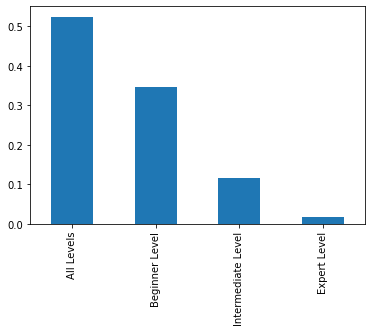

In [12]:
(cat_cols_df['level'].value_counts() / cat_cols_df.shape[0]).plot(kind = "bar")

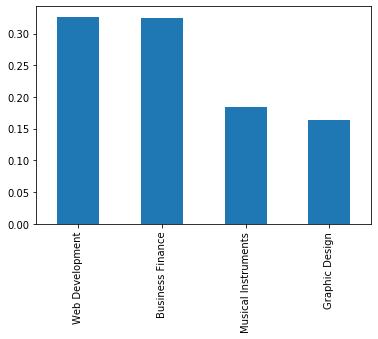

In [13]:
(cat_cols_df['subject'].value_counts() / cat_cols_df.shape[0]).plot(kind = "bar")

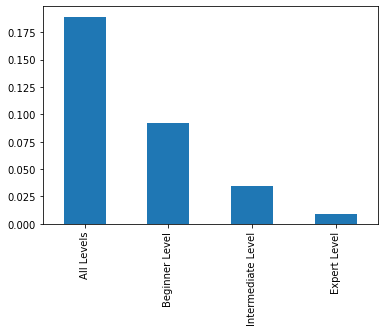

In [14]:
(cat_cols_df[cat_cols_df['subject'] == 'Business Finance']
['level'].value_counts() / cat_cols_df.shape[0]).plot(kind = "bar")

## Combining Features

In this case, I'll divide 'content_duration' by 'num_lectures' to figure out average lenght of lecture in hours.

C:\miniconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0.1074058333281294

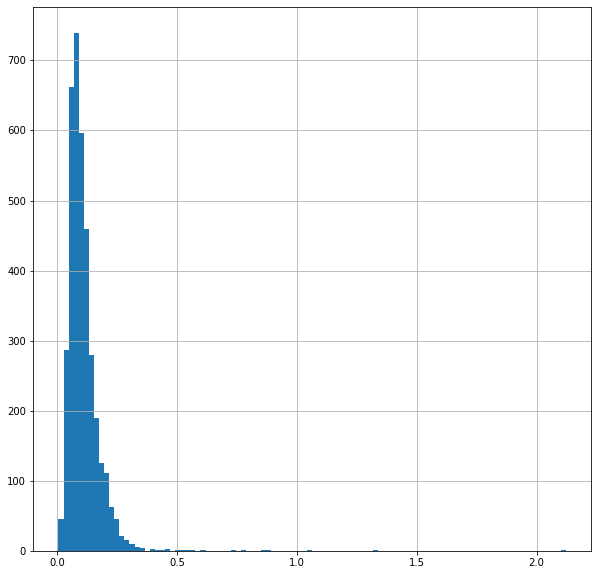

In [15]:
num_cols_df["average_lecture_length"] = num_cols_df["content_duration"]/num_cols_df["num_lectures"]
num_cols_df["average_lecture_length"].hist(figsize = (10, 10), bins = 100)
num_cols_df["average_lecture_length"].mean()

C:\miniconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


240598.50870038065

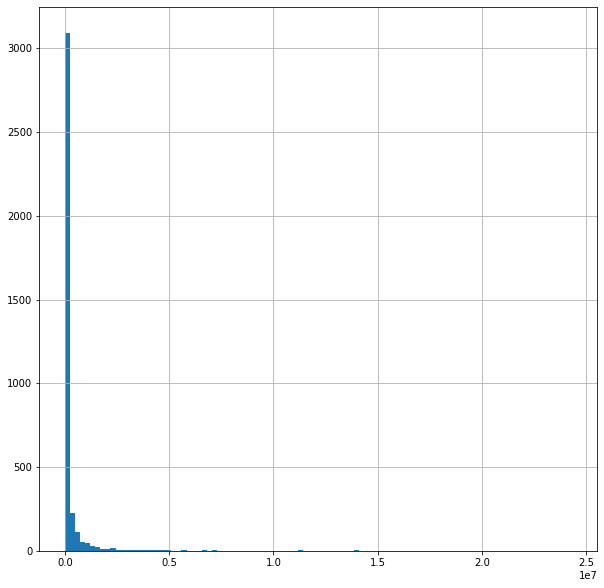

In [16]:
num_cols_df["revenue"] = num_cols_df["price"] * num_cols_df["num_subscribers"]
num_cols_df["revenue"].hist(figsize = (10, 10), bins = 100)
num_cols_df["revenue"].mean()

## Comparing Features with Target Variable

To compare against our target variable 'revenue', we can use the Seaborn library. This can help us figure out what features to include in the model (or remove later).

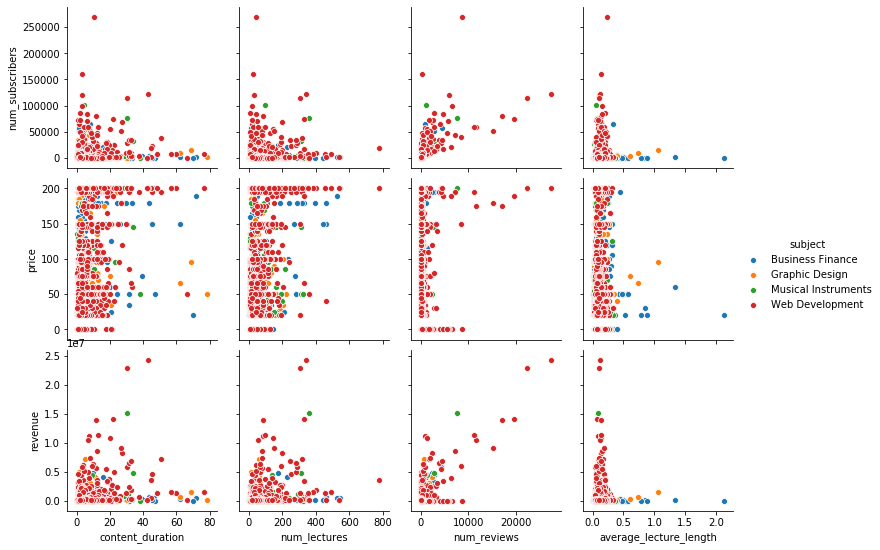

In [18]:
temp_df = pd.concat([num_cols_df, cat_cols_df], axis = 1)
sns.pairplot(temp_df, x_vars = ['content_duration', 'num_lectures', 'num_reviews', 'average_lecture_length'], y_vars = ['num_subscribers', 'price', 'revenue'], hue = 'subject')

## Building a Model

We start our data pipeline by preparing numerical and categorical columns from earlier separately. If we had any null values, we could drop or impute missing values in the data by applying one of the following lambda functions.

fill_mean = lambda col: col.fillna(col.mean())
fill_mode = lambda col: col.fillna(col.mode()[0])
fill_median = lambda col: col.fillna(col.median())

For 'cat_cols_df' we create dummy variable columns using pd.get_dummies(). We'll remove 'course_title' and 'course_url' as those are unlikely to be useful at the moment. The following function creates dummy columns for each col specifc in 'cat_cols'.

In [19]:
#preprocessing
cat_cols_df = cat_cols_df.iloc[:,2:]

In [20]:
def create_dummy_df(df, cat_cols, dummy_na):
    for col in cat_cols:
        try:
            #for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis = 1), pd.get_dummies(df[col], prefix = col, prefix_sep = '_', drop_first = False, dummy_na = dummy_na)], axis = 1)
        except:
            continue
    return df

In [21]:
cat_cols_df = create_dummy_df(cat_cols_df, cat_cols_df.columns, dummy_na = False)

In [24]:
from sklearn.model_selection import train_test_split

X_num_cols_df = num_cols_df[['content_duration','num_lectures','num_reviews','price']]
X = pd.concat([X_num_cols_df,cat_cols_df],axis = 1)
y = num_cols_df['revenue']

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

## Mean Squared Error (MSE)

After fitting the model, we predict success based on the X_test data and took for its mean squared error (MSE), a commonly used scoring metric.

In [25]:
from sklearn.linear_model import LinearRegression

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit

from sklearn.metrics import mean_squared_error

y_test_preds = lm_model.predict(X_test)
mse_score = mean_squared_error(y_test, y_test_preds)
length_y_test = len(y_test)

print("The MSE for your model was {} on {} values.".format(mse_score, length_y_test))

lm_model.coef_

The MSE for your model was 311921876295.66034 on 1104 values.


array([ 2.02853837e+03,  1.08114570e+03,  8.09803412e+02,  4.07603870e+03,
        2.10690474e+19,  2.10690474e+19,  2.10690474e+19,  2.10690474e+19,
       -4.83500501e+18, -4.83500501e+18, -4.83500501e+18, -4.83500501e+18])

## Improving and Deploying the Model

Now, the model clearly is terrible, so let's try understand why. More often then not, your first model will be really far off, that's ok, a lot of the real works comes from choosing subsets of features, cross validating/ensemble methods, or using different models!

However before that, it's very important to learn about the domain of your data the best that you can, there are likely events and trends not captured in the data that may be ruining your model. Udemy often does cuts the price of all their courses to $10, regardless of initial price. It could be worth removing 'prices' unless we are able to find average sale price of a class. I would also recommned digging more into the third step **Comparing Features with Target Variable**, as understanding patters better will help drive insights and do more than just tweaking the model itself.

Another way to improve the model could be to apply **natural language processing (NLP)** on the 'course_title' column to see if the presence of certain keywords has an effect.

The easiest method to share this model would be to put all your code in a **Jupyter Notebook** and **Binder** it. If you desire a cleaner UI you can create a **Plotly Dash** app and deploy it on **Heroku**.